# Chapter 2 w/ Exercises

In [4]:
DATASETS_PATH = "/datasets/"


In [8]:
!pip3 install -U matplotlib numpy pandas scipy scikit-learn

Requirement already up-to-date: matplotlib in c:\users\marksan\appdata\local\programs\python\python38\lib\site-packages (3.3.4)
Requirement already up-to-date: numpy in c:\users\marksan\appdata\local\programs\python\python38\lib\site-packages (1.20.1)
Requirement already up-to-date: pandas in c:\users\marksan\appdata\local\programs\python\python38\lib\site-packages (1.2.3)
Requirement already up-to-date: scipy in c:\users\marksan\appdata\local\programs\python\python38\lib\site-packages (1.6.1)
Requirement already up-to-date: scikit-learn in c:\users\marksan\appdata\local\programs\python\python38\lib\site-packages (0.24.1)
OK


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [196]:
import os
import tarfile
import urllib
import sklearn.model_selection
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from zlib import crc32
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from scipy import stats

In [13]:
#Download the datasets
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH=os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT +"datasets/housing/housing.tgz"
def fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH):
    os.makedirs(housing_path, exist_ok = True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
def load_housing_data(housing_path = HOUSING_PATH):
    csv_path = os.path.join(housing_path,"housing.csv")
    return pd.read_csv(csv_path)
fetch_housing_data()

In [15]:
#Lets see some data
housing = load_housing_data()
housing.head()
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [16]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [17]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


## Visualize Data
* hist()
* plot()
* corr()

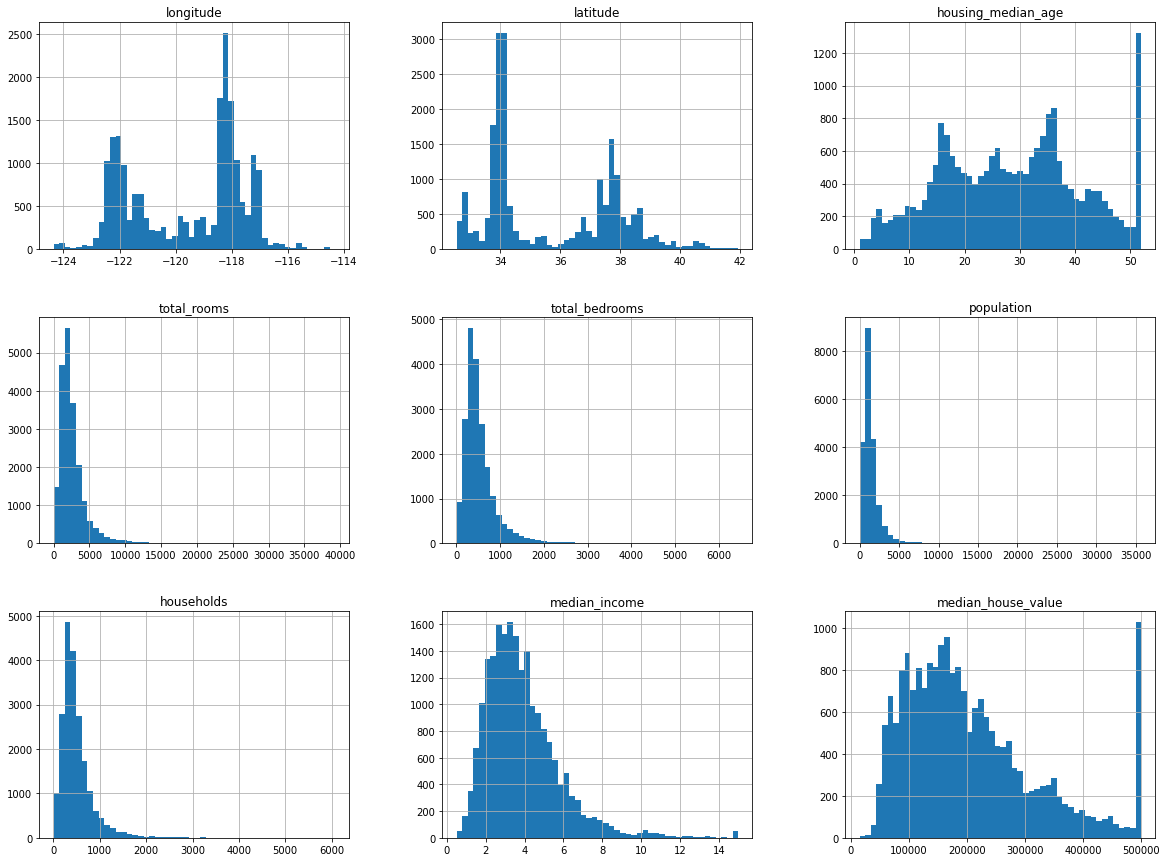

In [19]:
#lets see some histograms
housing.hist(bins = 50, figsize= (20,15))
plt.show()

In [32]:
#Lets process some data
def split_train_test(data, test_ratio):
    np.random.seed(30)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]
#Hash the test set so its constant
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32
def split_train_test_by_id(data,test_ratio, id_column):
    ids=data[id_column]
    in_test_set = ids.apply (lambda id_: test_set_check(id_,test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id,0.2,"index")
train_set.head()
    

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
6,6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY


In [34]:
#use sklearn train test split
train_set, test_set = sklearn.model_selection.train_test_split(housing, test_size = 0.2, random_state = 30)

<AxesSubplot:>

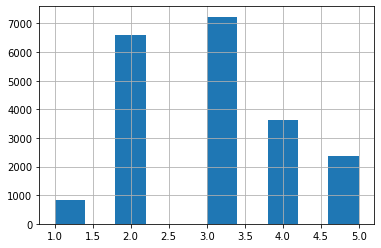

In [36]:
#Lets balance some data
housing["income_cat"] = pd.cut(housing["median_income"],
                                bins = [0.,1.5,3.0,4.5,6.,np.inf],
                                labels = [1,2,3,4,5])
housing['income_cat'].hist()


In [37]:
#Lets use some sklearn sampling

split = sklearn.model_selection.StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 30)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [39]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis = 1, inplace = True)


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

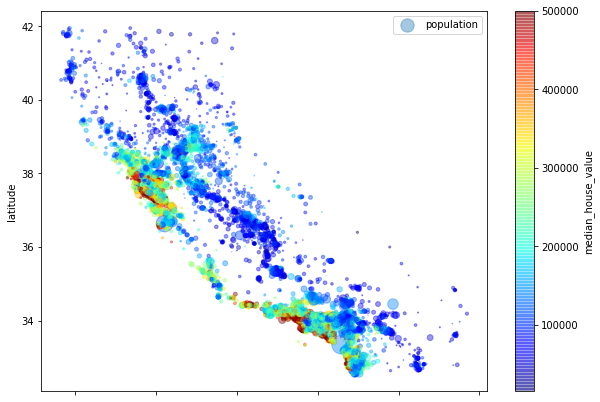

In [44]:
housing = strat_train_set.copy()
housing.plot(kind = "scatter", x = "longitude", y = "latitude", alpha = 0.4,
            s = housing["population"]/100, label = "population",
            c = "median_house_value", cmap = plt.get_cmap("jet"), colorbar = True, figsize = (10,7))

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

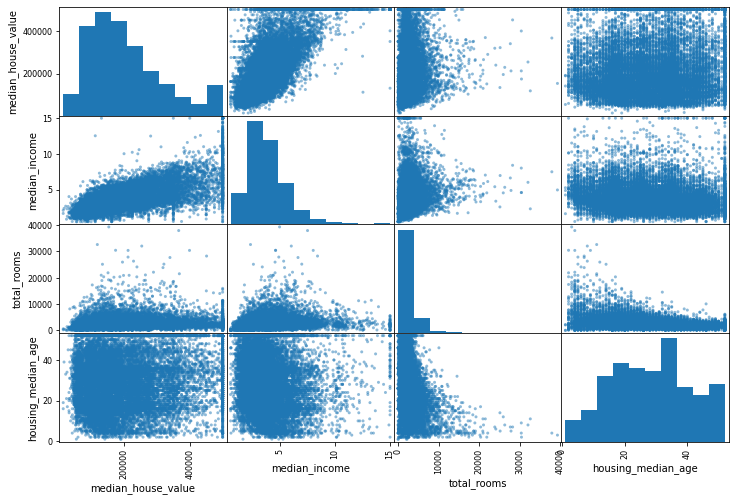

In [50]:
corr_matrix = housing.corr()
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize = (12,8))

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

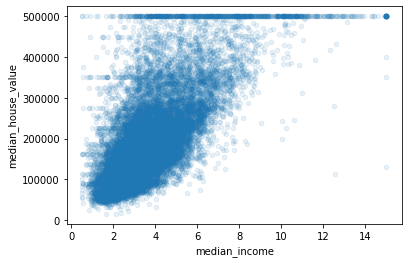

In [51]:
housing.plot(kind = "scatter", x = "median_income", y = "median_house_value", alpha= 0.1)

In [62]:
housing["rooms_per_househould"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]
corr_matrix = housing.corr()
print(corr_matrix["median_house_value"].sort_values(ascending= False))

median_house_value          1.000000
median_income               0.690493
rooms_per_househould        0.156676
total_rooms                 0.133722
housing_median_age          0.101441
households                  0.063815
total_bedrooms              0.047291
population                 -0.022589
population_per_household   -0.031649
longitude                  -0.046851
latitude                   -0.143953
bedrooms_per_room          -0.263182
Name: median_house_value, dtype: float64


## Data Preparation
* SimpleImputer()
* OneHotEncoder()
* CustomEncoder()

In [63]:
#Prepare data

housing = strat_train_set.drop("median_house_value", axis = 1)
housing_labels = strat_train_set["median_house_value"].copy()

In [69]:
imputer = SimpleImputer(strategy = "median")
housing_numerical = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_numerical)
X = imputer.transform(housing_numerical)
housing_tr = pd.DataFrame(X, columns = housing_numerical.columns, index =  housing_numerical.index)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
20594,-121.57,39.16,21.0,1872.0,302.0,870.0,301.0,3.7250
377,-122.16,37.75,35.0,667.0,140.0,406.0,133.0,3.8047
11228,-117.94,33.81,24.0,4602.0,1131.0,3003.0,1014.0,3.6771
3843,-118.45,34.19,11.0,2479.0,900.0,2466.0,855.0,2.2264
10801,-117.95,33.63,29.0,1496.0,282.0,463.0,215.0,6.0516


In [74]:
housing_cat = housing[["ocean_proximity"]]

In [84]:
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [87]:
housing_cat_encoded[:10]
housing_cat_1hot[:10]
cat_encoder.categories_


[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [114]:
#sample custom transformer

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CustomTransformer(BaseEstimator,TransformerMixin):
    def __init__(self, add_bedrooms_per_rooms =True):
        self.add_bedrooms_per_rooms= add_bedrooms_per_rooms
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        rooms_per_household = X[:, rooms_ix]/X[:,households_ix]
        population_per_household = X[:, population_ix]/X[:,households_ix]
        if self.add_bedrooms_per_rooms:
            bedrooms_per_room = X[:, bedrooms_ix]/X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        return np.c_[X, rooms_per_household, population_per_household]
attr_adder = CustomTransformer(add_bedrooms_per_rooms = False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [ ]:
#minmax scaling = normalization

## Transformation Pipelines
* Custom transformers must have fit_transform()
* ("name", Transformer(), indices)

In [115]:
#sample pipeline
num_pipeline = Pipeline([
        ('imputer',SimpleImputer(strategy = "median")),
        ('attribs_adder', CustomTransformer()),
        ('std_scaler', StandardScaler()),
])
housing_num_tr = num_pipeline.fit_transform(housing_numerical)
print(housing_num_tr.shape)


(16512, 11)


In [122]:
#handle both categorical and numerical features
numerical_attributes = list(housing_numerical)
print(numerical_attributes)
categorical_attributes = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("numerical", num_pipeline, numerical_attributes),
        ("categorical", OneHotEncoder(), categorical_attributes)
])
housing
housing_prepared = full_pipeline.fit_transform(housing)

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']


## Select and Train a Model
* LinearRegression()
* DecisionTreeRegressor()
* RandomForestRegressor()

In [136]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels,housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

68226.57622849161


In [145]:
dec_tree = DecisionTreeRegressor()
dec_tree.fit(housing_prepared,housing_labels)
housing_predictions_dec = dec_tree.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions_dec)
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

0.0


In [148]:
rand_forest= RandomForestRegressor()


## Cross Validation

In [149]:
scores = cross_val_score(dec_tree, housing_prepared, housing_labels, scoring = "neg_mean_squared_error",cv = 10)
tree_rmse = np.sqrt(-scores)
print(tree_rmse)
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring = "neg_mean_squared_error",cv = 10)
lin_reg_rmse = np.sqrt(-scores)
print(lin_reg_rmse)

[66822.37181224 69007.22523606 67093.32820458 68465.68200489
 75718.00614649 71876.68851214 69406.24729408 70988.49388454
 73284.4337775  73729.71854535]
[66315.85024382 67733.57265222 66864.65133995 67191.87222343
 70925.26012793 71891.67856623 70935.36506684 67690.91341525
 66601.34147789 69486.25937474]
[66315.85024382 67733.57265222 66864.65133995 67191.87222343
 70925.26012793 71891.67856623 70935.36506684 67690.91341525
 66601.34147789 69486.25937474]


KeyboardInterrupt: 

In [151]:
scores = rand_forest.fit(housing_prepared,housing_labels)
preds = scores.predict(housing_prepared)
mse = mean_squared_error(housing_labels,preds)
rmse = np.sqrt(mse)
print(rmse)

TypeError: loop of ufunc does not support argument 0 of type DecisionTreeRegressor which has no callable sqrt method

## Shortlist 2-5 Models
* Elastic Net
* Ridge 
* Lasso
* BayesianRidge

In [165]:
elasticnet = ElasticNet()
enet = elasticnet.fit(housing_prepared,housing_labels)
scores = cross_val_score(enet, housing_prepared, housing_labels, scoring = "neg_mean_squared_error",cv = 10)
enet_rmse = np.sqrt(-scores)
print(enet_rmse.sum()/len(enet_rmse))

78293.65363109816


In [164]:
b_ridge = linear_model.BayesianRidge()
bridge = b_ridge.fit(housing_prepared,housing_labels)
scores = cross_val_score(bridge, housing_prepared, housing_labels, scoring = "neg_mean_squared_error",cv = 10)
bridge_rmse = np.sqrt(-scores)
print(bridge_rmse.sum()/len(bridge_rmse))

68561.83440566924


In [166]:
ridge = linear_model.Ridge()
ridge = ridge.fit(housing_prepared,housing_labels)
scores = cross_val_score(ridge, housing_prepared, housing_labels, scoring = "neg_mean_squared_error",cv = 10)
ridge_rmse = np.sqrt(-scores)
print(ridge_rmse.sum()/len(ridge_rmse))

68560.35410103005


In [167]:
lasso = linear_model.Lasso()
lasso = lasso.fit(housing_prepared,housing_labels)
scores = cross_val_score(lasso, housing_prepared, housing_labels, scoring = "neg_mean_squared_error",cv = 10)
lasso_rmse = np.sqrt(-scores)
print(lasso_rmse.sum()/len(lasso_rmse))

c:\users\marksan\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6270256683555.328, tolerance: 21908467261.968674
  model = cd_fast.enet_coordinate_descent(
c:\users\marksan\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5676290630978.398, tolerance: 19834738254.804226
  model = cd_fast.enet_coordinate_descent(
c:\users\marksan\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5696115187082.602, tolerance: 19857663843.19256
  model = cd_fast.enet_coordinate_descent(
c:\users\marks

68563.41213417883


c:\users\marksan\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5617248143884.039, tolerance: 19607330969.026474
  model = cd_fast.enet_coordinate_descent(


## Grid search for hyperparameters

In [172]:
param_grid = [
    {'n_estimators': [30], 'max_features': [6,8]}
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv = 5,
                          scoring = "neg_mean_squared_error",
                          return_train_score = True)
grid_search.fit(housing_prepared,housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [6, 8], 'n_estimators': [30]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [174]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49646.01315502447 {'max_features': 6, 'n_estimators': 30}
49750.26713167514 {'max_features': 8, 'n_estimators': 30}


In [189]:
feature_importances=grid_search.best_estimator_.feature_importances_

In [190]:
extra_attributes = ["rooms_per_household", "pop_per_household", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["categorical"]
one_hots = list(cat_encoder.categories_[0])
attributes_full = numerical_attributes + extra_attributes + one_hots
sorted(zip(feature_importances,attributes_full), reverse= True)

[(0.32585442751942667, 'median_income'),
 (0.1495861244091257, 'INLAND'),
 (0.10304755444418573, 'pop_per_household'),
 (0.08208345328890648, 'bedrooms_per_room'),
 (0.08146828883096177, 'longitude'),
 (0.07094672282523697, 'latitude'),
 (0.057047967223587535, 'rooms_per_household'),
 (0.04076423103422615, 'housing_median_age'),
 (0.017318261876475647, 'population'),
 (0.016951161493743726, 'total_rooms'),
 (0.016015262241953307, 'total_bedrooms'),
 (0.015174136238902397, 'households'),
 (0.012409023877557483, '<1H OCEAN'),
 (0.007309449584942592, 'NEAR OCEAN'),
 (0.0038502666031158565, 'NEAR BAY'),
 (0.0001736685076519978, 'ISLAND')]

## Testing

In [191]:
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis = 1)
y_test = strat_test_set["median_house_value"].copy()

In [195]:
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test,final_predictions)
final_rmse=np.sqrt(final_mse)
print(final_rmse)

48025.80304735056


## Confidence Interval

In [197]:
confidence = 0.95
squared_errors = (final_predictions - y_test)**2
np.sqrt(stats.t.interval(confidence, len(squared_errors)-1,
                        loc = squared_errors.mean(),
                        scale = stats.sem(squared_errors)))

array([45700.72833963, 50243.39703795])